Taking the output from DEG-SEQ2, the data "5LS_L2L3Combined.csv" contains the 5 life stages we are interested in:
Embryo, L1 larva, Dauer Larva, L2L3 Larva and Adult, lets take a peek of that data

In [1]:
import csv
import os

#user configurable variables
number_of_lines_to_print=10
expressionCountFile=os.path.join(os.getcwd(),'csvs/5LS_L2L3Combined.csv')
#Code Chunk for printing the file
with open(os.path.join(os.getcwd(),expressionCountFile)) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        print(row)
        number_of_lines_to_print-=1
        if number_of_lines_to_print<=0:
            break
        
        

['WBID', 'elongating embryo Ce', 'L1 larva Ce', 'dauer larva Ce', 'adult Ce', 'L2L3_larva']
['WBGene00000001', '4208', '12140', '5547', '2246', '2369']
['WBGene00000002', '12554', '7828', '831', '280', '2591']
['WBGene00000003', '7180', '11253', '570', '212', '2466']
['WBGene00000004', '33305', '26947', '3212', '576', '5391']
['WBGene00000005', '595', '132', '37', '281', '1410']
['WBGene00000006', '425', '12243', '3146', '228', '2446']
['WBGene00000007', '36', '314', '129', '197', '1719']
['WBGene00000008', '0', '19', '663', '19', '182']
['WBGene00000009', '71', '416', '193', '20', '64']


Lets look at some statistics about the data:

In [2]:
import pandas as pd 
import numpy as np

exp_data = pd.read_csv(expressionCountFile)
print(exp_data.describe())

       elongating embryo Ce   L1 larva Ce  dauer larva Ce      adult Ce  \
count          20361.000000  2.036100e+04    2.036100e+04  2.036100e+04   
mean            3692.118364  1.097686e+04    3.908223e+03  2.065875e+03   
std            12796.637118  5.382926e+04    2.111976e+04  2.269343e+04   
min                0.000000  0.000000e+00    0.000000e+00  0.000000e+00   
25%                8.000000  5.700000e+01    2.700000e+01  5.000000e+00   
50%              201.000000  7.240000e+02    4.030000e+02  8.600000e+01   
75%             2730.000000  4.645000e+03    2.375000e+03  8.690000e+02   
max           355180.000000  1.890193e+06    1.303599e+06  2.253663e+06   

         L2L3_larva  
count  2.036100e+04  
mean   4.178275e+03  
std    1.964655e+04  
min    0.000000e+00  
25%    2.900000e+01  
50%    3.910000e+02  
75%    2.292000e+03  
max    1.103229e+06  


Now, we need to determine the genes that we consider to be life stage biased, here are the some criterias that must be fullfilled to be considered a life stage biased gene:

<ol start="1">   
  <li>This gene has the highest expression in that life stage</li>
  <li>This gene's expression at this life stage has at least a fold difference of 2 comparing the max expression in other life stages</li>
  <li>At least one life stage has a count that is higher than at least 10% of of counts across all life stages. <br>
      <font size="2">*This ensures we dont include genes that have high fold diff due to unbalanced low expression counts, for example, a gene has a count of 1 in one life stage and are not found in other life stages(0 counts),this gene is a uniformly lowly expressed gene in all life stages, however, using the criteria one, this gene would have a fold difference of infinity, by setting a lower bound filter, we exclude these extremely lowly expressed gene counts that are prone to sequencing uncertainties. </font> </li>

</ol>


Let's process the expression file using above criterias:

In [3]:
from Code import LifeStageBiased as LSB
#Speficy input and output
LSB.inputFile= expressionCountFile
outputFilePath=os.path.join(os.getcwd(),'csvs/LSB.csv')
LSB.outputFile= outputFilePath
LSB.cutLowPercentile=0.15
LSB.foldDiff=2
LSB.fixedCutValue=0 #This overrides the percentil cut value, set to 0 disables it
LSB.main()


The cutOff Value for the specified percentaile is:  5.0


*In the data we are analyzing, there are very few genes that have observed expression only in one life stage, in which case the max expression for other life stages is 0, this will yield infinity for the fold diff value, in theory, these are "life stage specific genes" rather than "life stage biased genes", however, since the same reason we mentioned above about the sequecing uncertainties, we do not believe that a gene with a few counts only in one life stage is more likely to be a life stage biased gene comparing to a gene with high expression in one life stage and very low expression in other life stages, see example below:</font> </li>


In [4]:


ls_data = pd.read_csv(outputFilePath)

print(ls_data.loc[ls_data['GeneID'] == "WBGene00015845"])
print()
print(ls_data.loc[ls_data['GeneID'] == "WBGene00000609"])


              GeneID        LS  LS_EXP  SecondMax  RestMean  FoldDiff
6043  WBGene00015845  adult Ce     7.0        0.0       0.0       7.0

             GeneID        LS   LS_EXP  SecondMax  RestMean    FoldDiff
218  WBGene00000609  adult Ce  71952.0      148.0     76.75  486.162162


As shown above, Gene "WBGene00015845" is a relatively lowly expressed gene that is only expressed in adult stage,
and "WBGene00000609" has significantly higher expression in adult stage comparing to other life stages, which one are we more confident to select as the life stage biased gene? 

There is no sure way to know, to compensate that, instead of putting infinity as the fold difference value for these "life stage specific" genes and put more confidence in them above all other genes, we decided to use their expression value as their foldDiff value, in which case a highly expressed "life stage specific" gene will be given higher confidence comparing to a lowly expressed one. 

We are aware that this is perhaps not the best way of handling these genes, but luckily, there are only 15 such genes out of the 10099 life stage biased genes(0.15%) we selected using above filter, so it is extremly unlikely that different handlings of these genes will make a significant difference.

Now the genes that fit into our criteria should be in the *outputFilePath* we set ealier, lets take a look at some basic statistics of these selected life stage biased genes:

Index(['GeneID', 'LS', 'LS_EXP', 'SecondMax', 'RestMean', 'FoldDiff'], dtype='object')
             LS_EXP      SecondMax       RestMean      FoldDiff  \
count  1.009900e+04   10099.000000   10099.000000  10099.000000   
mean   1.679783e+04    4102.327656    2191.947742     15.490207   
std    7.351532e+04   19035.148534   10168.396260    176.069930   
min    5.000000e+00       0.000000       0.000000      2.000000   
25%    1.560000e+02      28.000000      12.250000      2.617371   
50%    1.298000e+03     248.000000     108.750000      3.776471   
75%    8.224500e+03    1946.000000     988.500000      6.722003   
max    2.253663e+06  540124.000000  315851.750000  12412.000000   

       FoldDiff_RestMean    LS_EXP_LOG  FoldDiff_LOG  RestMean_LOG  \
count       1.009900e+04  10099.000000  10099.000000  1.009900e+04   
mean                 inf      7.073785      1.586584          -inf   
std                  NaN      2.538669      0.907085           NaN   
min         2.181818e+00     

/home/lu/.local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


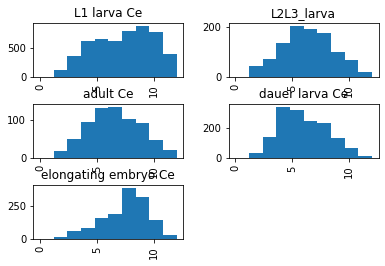

In [5]:

ls_data.head()
print(ls_data.columns)

ls_data[["LS_EXP","SecondMax","FoldDiff"]]=ls_data[["LS_EXP","SecondMax","FoldDiff"]].apply(pd.to_numeric)
ls_data.sort_values(by=['FoldDiff'],ascending=False)
ls_data['FoldDiff_RestMean']=ls_data["LS_EXP"]/ls_data["RestMean"]
ls_data['LS_EXP_LOG']=np.log((ls_data['LS_EXP']))
ls_data['FoldDiff_LOG']=np.log((ls_data['FoldDiff']))
ls_data['RestMean_LOG']=np.log((ls_data['RestMean']))
ls_data["FoldDiff_RestMean_LOG"]= np.log(ls_data["FoldDiff_RestMean"])

print(ls_data.describe())
print()
print("ls_data Summary By Life Stage Group")
print(ls_data.groupby("LS").describe())

ax=ls_data['LS_EXP_LOG'].hist(by=ls_data['LS'],range=[0,12])



<AxesSubplot:xlabel='LS_EXP_LOG', ylabel='FoldDiff_LOG'>

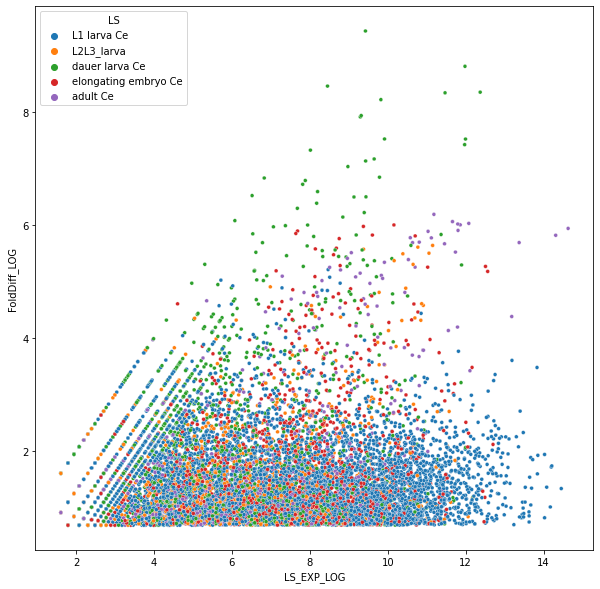

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns



ax2=plt.figure(figsize=[10,10])
sns.scatterplot(x='LS_EXP_LOG',y='FoldDiff_LOG',hue='LS', data=ls_data,s=15)



<Figure size 1440x1440 with 0 Axes>

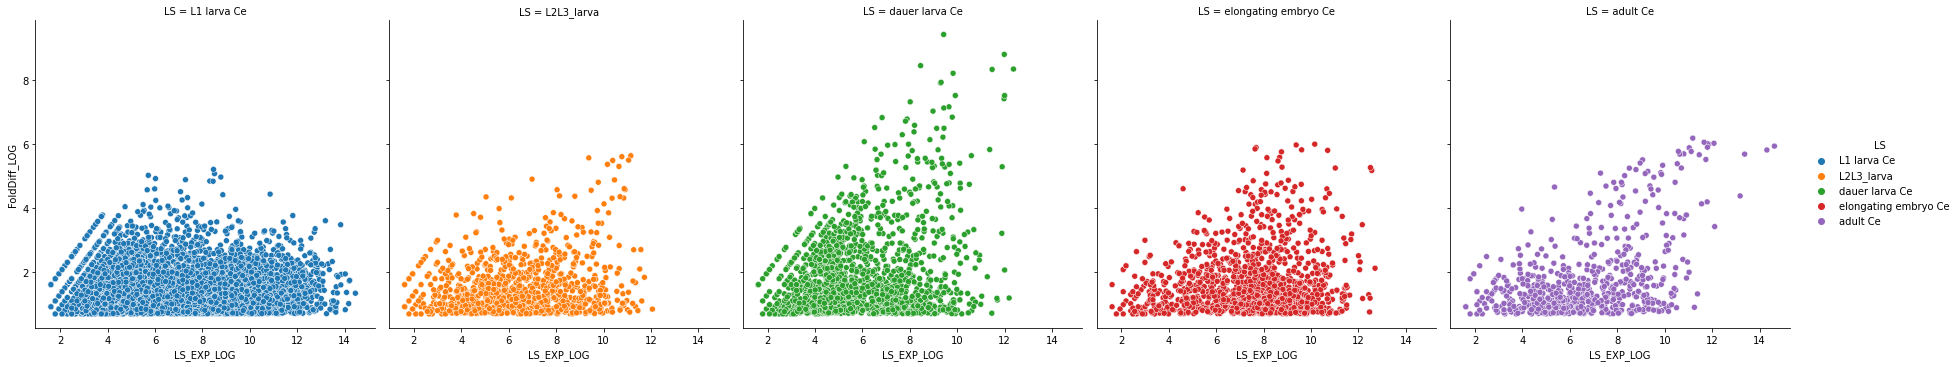

In [7]:

ax3=plt.figure(figsize=[20,20])
sns.relplot(
    data=ls_data,x='LS_EXP_LOG', y="FoldDiff_LOG",
    col="LS", hue="LS", 
    kind="scatter"
)

Look at the relationship bettween the max expression vs mean of expression in other life stages

<Figure size 1440x1440 with 0 Axes>

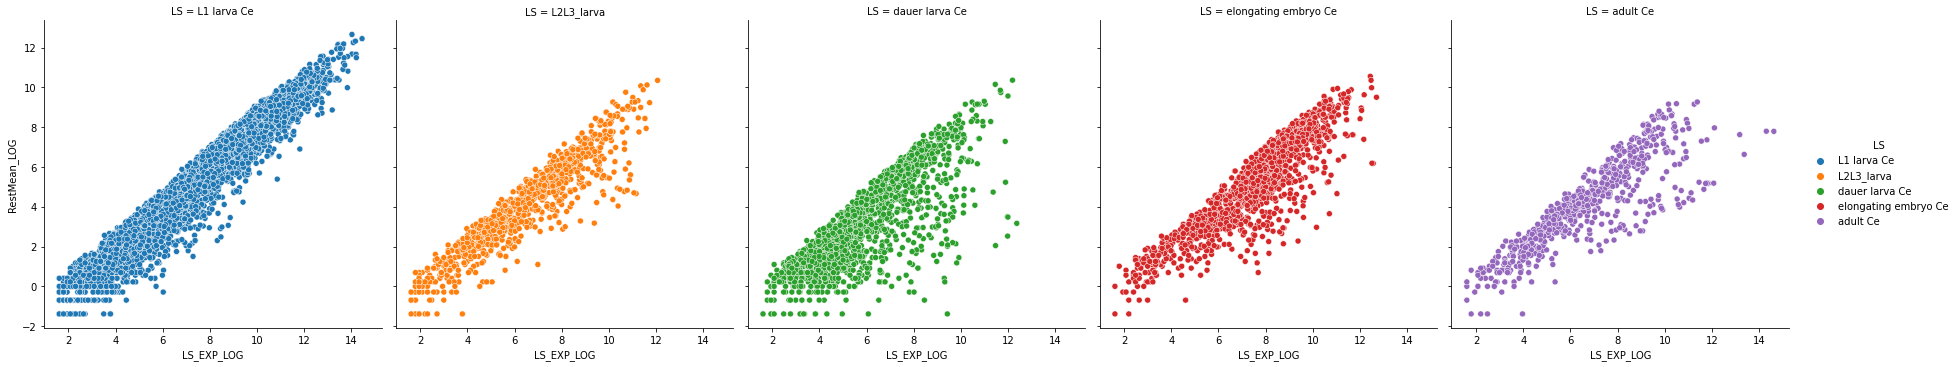

In [8]:

ax4=plt.figure(figsize=[20,20])

splot=sns.relplot(
    data=ls_data,x='LS_EXP_LOG', y="RestMean_LOG",
    col="LS", hue="LS", 
    kind="scatter"
)



Now, lets look at the number of genes from each life stage selected when we change the threshhold:

Threshold of FoldDiff: 2
             LS_EXP      SecondMax       RestMean      FoldDiff  \
count  1.009900e+04   10099.000000   10099.000000  10099.000000   
mean   1.679783e+04    4102.327656    2191.947742     15.490207   
std    7.351532e+04   19035.148534   10168.396260    176.069930   
min    5.000000e+00       0.000000       0.000000      2.000000   
25%    1.560000e+02      28.000000      12.250000      2.617371   
50%    1.298000e+03     248.000000     108.750000      3.776471   
75%    8.224500e+03    1946.000000     988.500000      6.722003   
max    2.253663e+06  540124.000000  315851.750000  12412.000000   

       FoldDiff_RestMean    LS_EXP_LOG  FoldDiff_LOG  RestMean_LOG  \
count       1.009900e+04  10099.000000  10099.000000  1.009900e+04   
mean                 inf      7.073785      1.586584          -inf   
std                  NaN      2.538669      0.907085           NaN   
min         2.181818e+00      1.609438      0.693147          -inf   
25%         5.582012e

             LS_EXP    SecondMax     RestMean      FoldDiff  \
count  2.430000e+02   243.000000   243.000000    243.000000   
mean   4.192780e+04   184.621399    80.042181    392.949462   
std    1.882614e+05   686.621839   282.602225   1069.972609   
min    7.500000e+01     0.000000     0.000000     64.000000   
25%    1.528500e+03     7.000000     3.500000     90.302020   
50%    5.698000e+03    32.000000    16.250000    135.000000   
75%    1.771950e+04   121.000000    52.875000    275.230000   
max    2.253663e+06  6635.000000  2439.000000  12412.000000   

       FoldDiff_RestMean  LS_EXP_LOG  FoldDiff_LOG  RestMean_LOG  \
count         243.000000  243.000000    243.000000    243.000000   
mean                 inf    8.639722      5.192860          -inf   
std                  NaN    1.927644      0.954800           NaN   
min            79.512195    4.317488      4.158883          -inf   
25%           198.666667    7.331232      4.503147      1.252763   
50%           329.444444

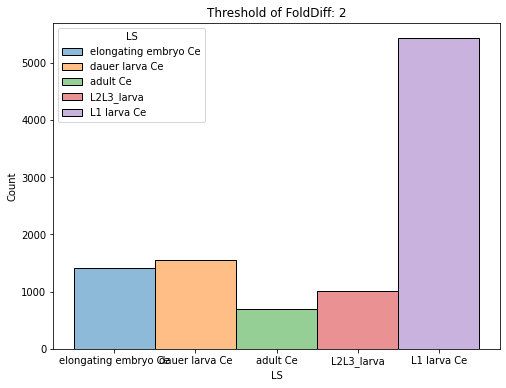

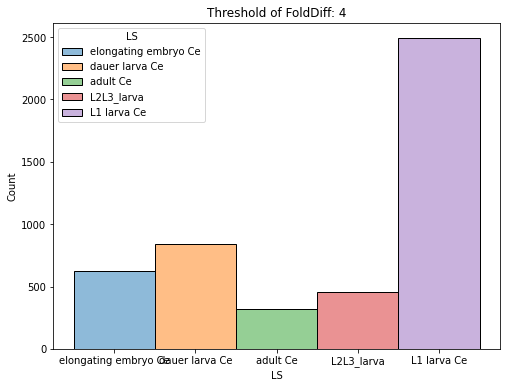

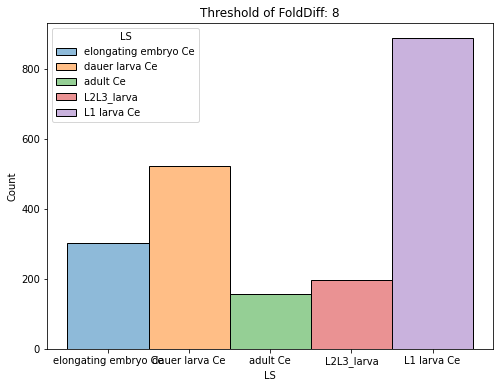

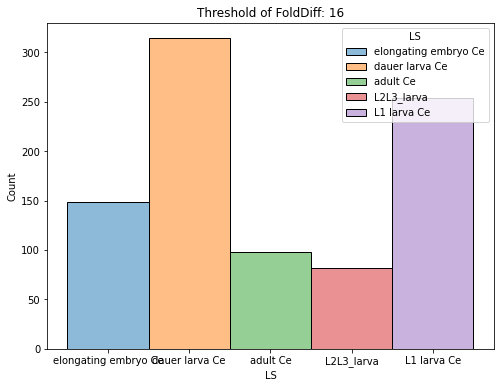

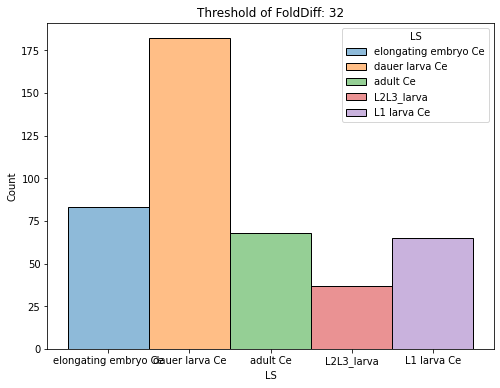

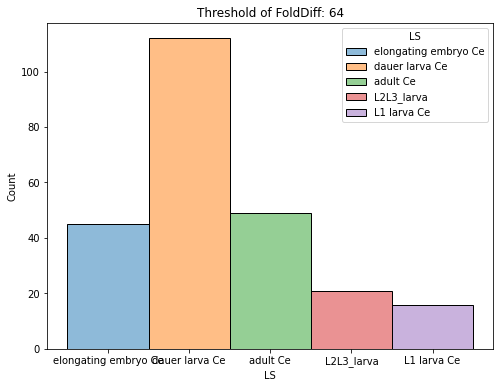

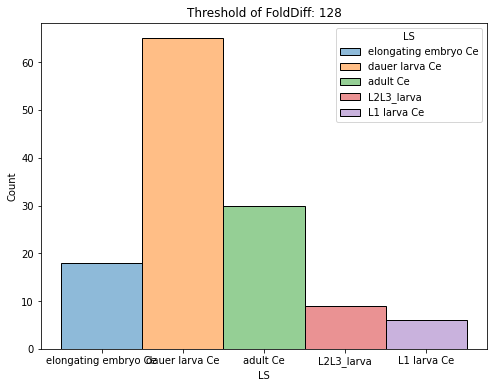

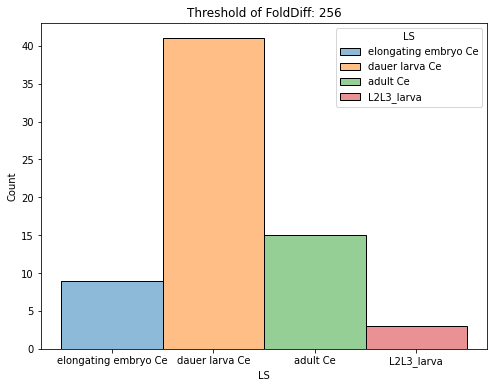

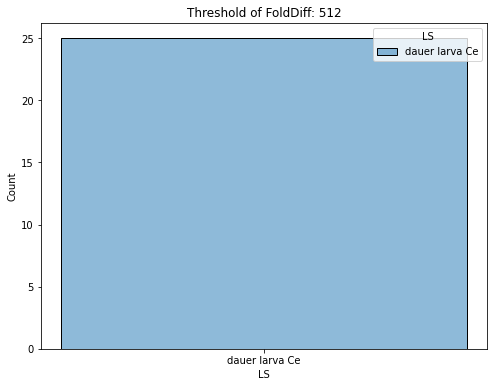

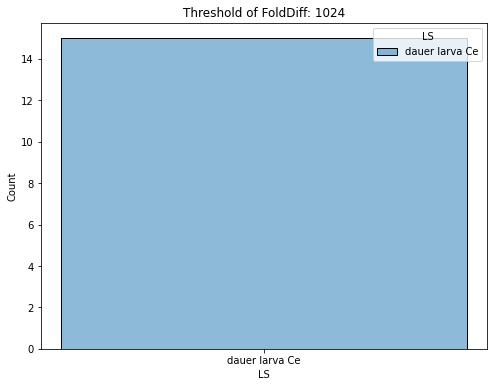

In [16]:
sorted_ls_data=ls_data.sort_values(['LS','FoldDiff'],ascending=False)

thresholds=[2**i for i in range(1,11)]
    
for threshold in thresholds:
    df_filtered=sorted_ls_data.loc[sorted_ls_data['FoldDiff'] >= threshold]
    df_count=df_filtered.groupby("LS").count()
    ax=plt.figure(figsize=[8,6])
    text=("Threshold of FoldDiff: "+ str(threshold))
    print(text)
    sns.histplot(df_filtered, x="LS",hue="LS").set_title(text)
    print(df_filtered.describe())

    


Below is the same figures useing foldDiff_RestMean rather than FoldDiff(second max)

<Figure size 1440x1440 with 0 Axes>

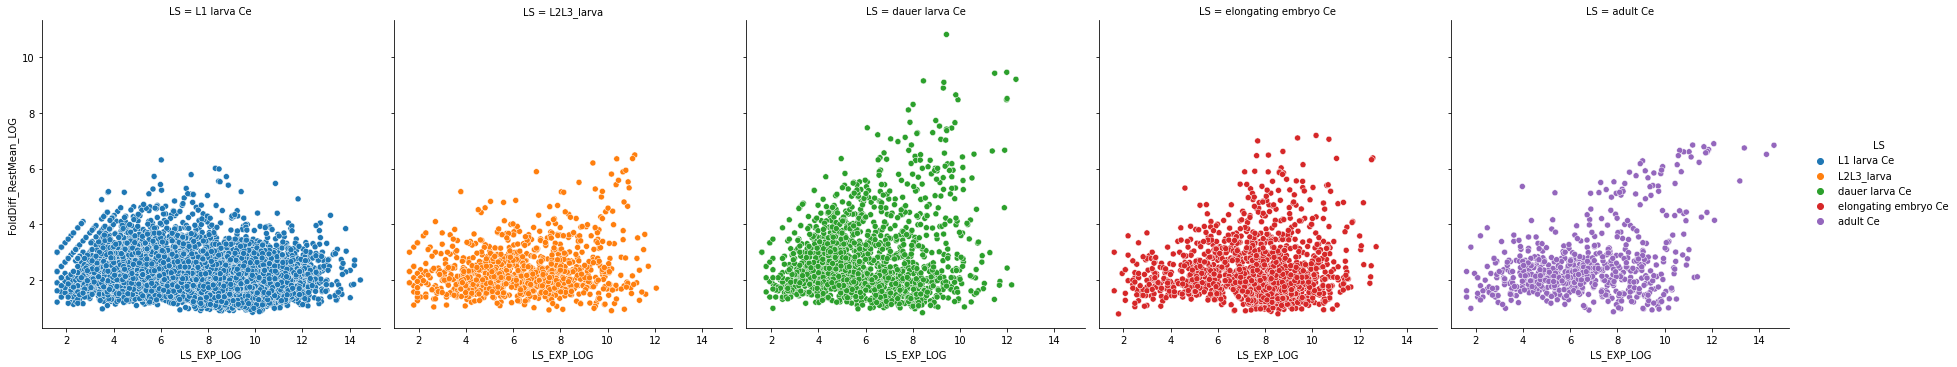

In [10]:

ax3=plt.figure(figsize=[20,20])
sns.relplot(
    data=ls_data,x='LS_EXP_LOG', y="FoldDiff_RestMean_LOG",
    col="LS", hue="LS", 
    kind="scatter"
)

<Figure size 1440x1440 with 0 Axes>

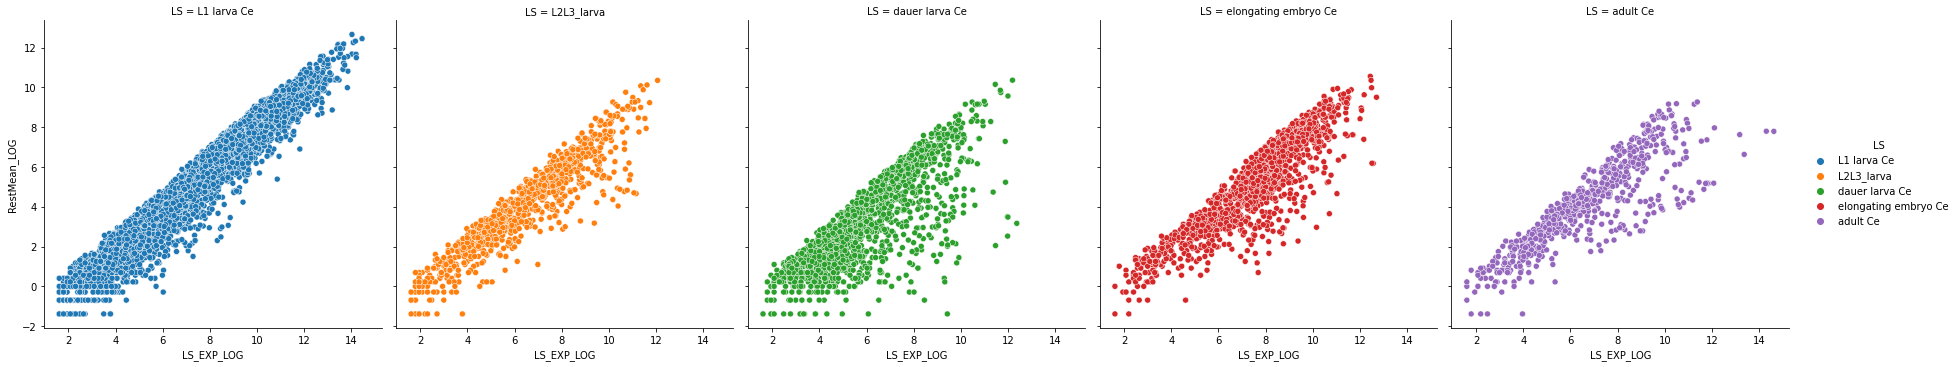

In [11]:

ax4=plt.figure(figsize=[20,20])

splot=sns.relplot(
    data=ls_data,x='LS_EXP_LOG', y="RestMean_LOG",
    col="LS", hue="LS", 
    kind="scatter"
)


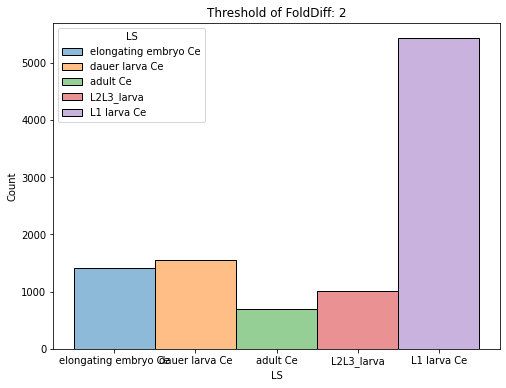

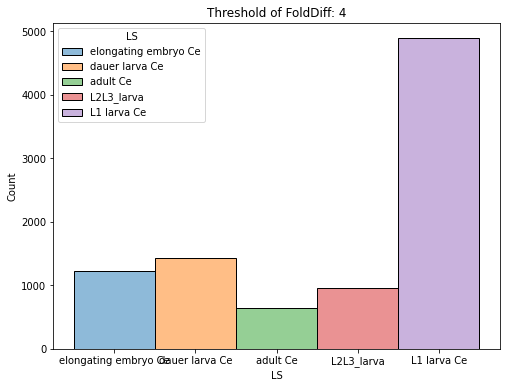

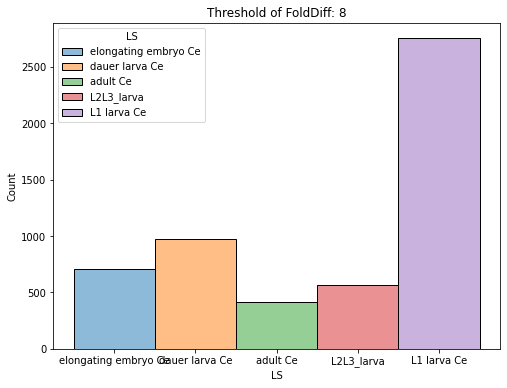

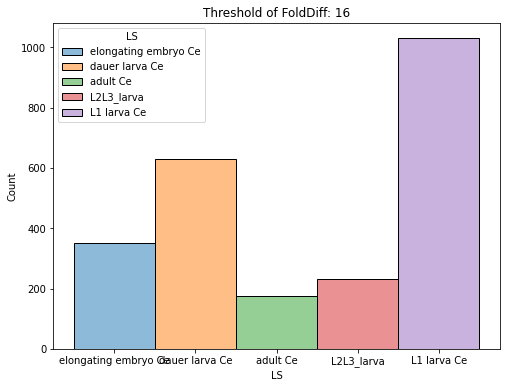

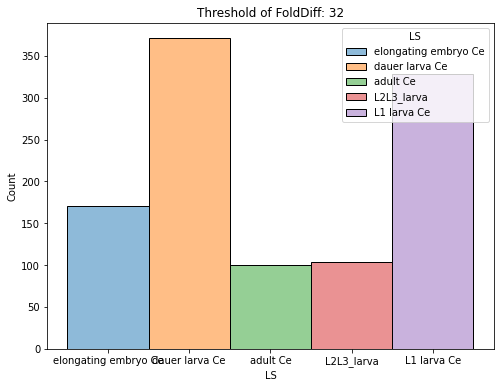

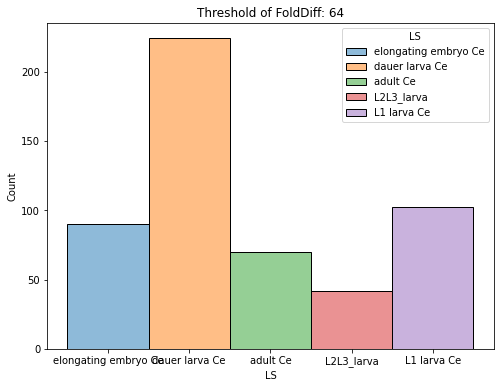

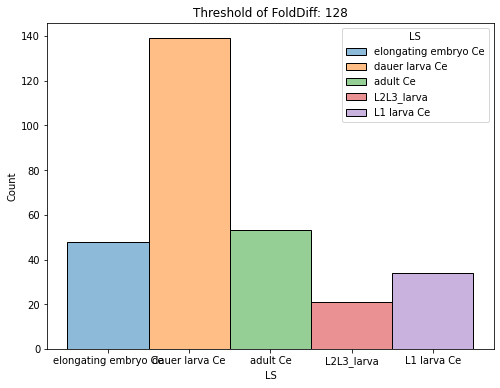

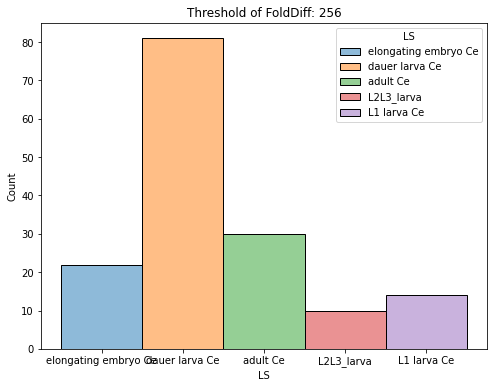

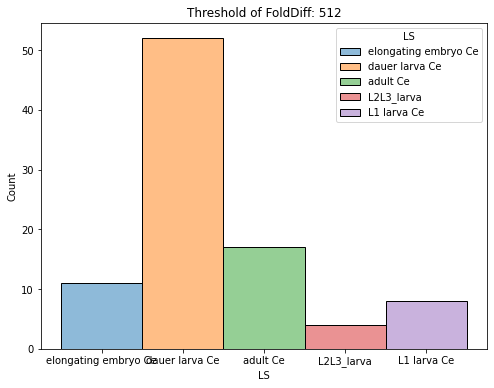

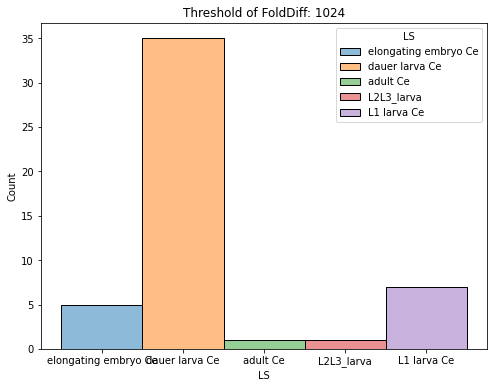

In [12]:
sorted_ls_data=ls_data.sort_values(['LS','FoldDiff_RestMean'],ascending=False)

thresholds=[2**i for i in range(1,11)]
    
for threshold in thresholds:
    df_filtered=sorted_ls_data.loc[sorted_ls_data['FoldDiff_RestMean'] >= threshold]
    df_count=df_filtered.groupby("LS").count()
    ax=plt.figure(figsize=[8,6])
    text=("Threshold of FoldDiff: "+ str(threshold))
    sns.histplot(df_filtered, x="LS",hue="LS").set_title(text)



/home/lu/.local/lib/python3.8/site-packages/numpy/core/function_base.py:144: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/lu/.local/lib/python3.8/site-packages/numpy/core/function_base.py:154: RuntimeWarning: invalid value encountered in add
  y += start


<AxesSubplot:xlabel='RestMean_LOG', ylabel='SecondMax_LOG'>

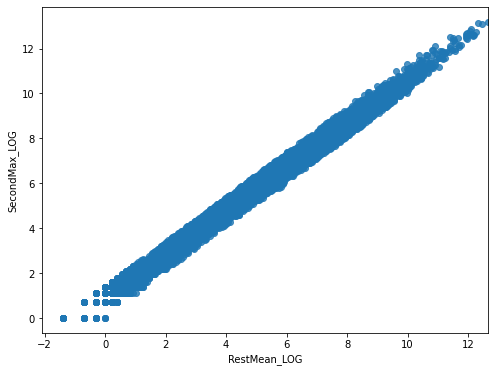

In [15]:

ax=plt.figure(figsize=[8,6])

ls_data["RestMean_LOG"]=np.log(ls_data["RestMean"])
ls_data["SecondMax_LOG"]=np.log(ls_data["SecondMax"])
sns.regplot(data=ls_data,x="RestMean_LOG",y="SecondMax_LOG")

Now,we are going to create the dataset for the input of ROC-SEMPPR, using two different approaches of selecting genes from the criteria above:

(1) Use a higher fold difference cutoff of 8, a cutoff increase from 2 to 8 increases our confidence on the genes selected, at the same time preserves enough genes that meet the criterias for further analysis.

In [ ]:
from Code import LifeStageBiased as LSB
#Speficy input and output
LSB.inputFile= expressionCountFile
outputFilePath=os.path.join(os.getcwd(),'csvs/LSB.csv')
LSB.outputFile= outputFilePath
LSB.cutLowPercentile=0.15
LSB.foldDiff=8
LSB.fixedCutValue=0 #This overrides the percentil cut value, set to 0 disables it
LSB.main()